# レギュラーシーズン vs ポストシーズン(10/13以降)

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tq

In [2]:
DATA_DIR = "../game_num_data/"

In [3]:
def filename_to_datetime(filename):
    year = filename[:4]
    month = filename[4:6]
    day = filename[6:8]
    return pd.to_datetime(year+month+day)

In [4]:
def make_df(start, end):
    case_index = 0
    inning_index = 1
    offense_team_index = 6
    defense_team_index = 2
    event_list = []
    file_list = os.listdir(DATA_DIR)[1:]
    
    date_series = pd.Series(file_list).apply(filename_to_datetime)
    target_file_list = list(pd.Series(file_list)[(date_series<pd.to_datetime(end)+pd.offsets.timedelta(1)) & (date_series>=pd.to_datetime(start))])
    
    columns = pd.read_csv(DATA_DIR+file_list[0], encoding="cp932", index_col=0, dtype="object").columns
    length = len(columns)
    
    for file in tq(target_file_list):
        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object").values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][case_index][0] == "2" and curr_event_list[i+1][case_index][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][inning_index]]+[np.nan for _ in range(length-2)])
                new_event_list.append(["0000", curr_event_list[i+1][inning_index]]+[np.nan for _ in range(length-2)])
        event_list.extend(new_event_list+[["GAMESET"]+[np.nan for _ in range(length-1)]])
        
    for i in range(len(event_list)):
        #print(event_list[i][inning_index])
        if event_list[i][inning_index] is np.nan:
            if event_list[i][case_index] != "GAMESET":
                event_list[i][inning_index] = event_list[i-1][inning_index]
                event_list[i][offense_team_index] = event_list[i-1][offense_team_index]
                event_list[i][defense_team_index] = event_list[i-1][defense_team_index]
                
    return pd.DataFrame(event_list, columns=columns)

In [5]:
def make_inning_list(event_df):
    case_index = 0
    inning_index = 1
    
    inning_list = []
    for inning in range(10):
        curr_inning_list = []
        for i in range(len(event_df)):
            if event_df.iloc[i, case_index] == "GAMESET":
                continue
            if int(event_df.iloc[i, inning_index].split("回")[0]) == inning + 1:
                curr_inning_list.append(event_df.iloc[i, case_index])
        inning_list.append(curr_inning_list)
    return inning_list

In [6]:
def make_inning_triple(inning_list):
    inning_triple_list = []
    for inning in range(len(inning_list)):
        curr_triple = []
        for i in range(2, len(inning_list[inning])):
            before, curr, after = inning_list[inning][i-2], inning_list[inning][i-1], inning_list[inning][i]
            if "GAMESET" in [before, curr, after]:
                continue
            if before == "3000" or curr == "3000":
                continue
            curr_triple.append((before, curr, after))
        inning_triple_list.append(curr_triple)
    return inning_triple_list

In [7]:
def make_flattened_list(nested_list):
    flattened_list = []
    for elem_list in nested_list:
        flattened_list += elem_list
    return flattened_list

In [8]:
def to_index(lst, dictionary):
    return [dictionary[elem] for elem in lst]

In [9]:
def ks_test(event_df, kind):
    """
    kind : "statistic" or "pvalue"
    """
    inning_list = make_inning_list(event_df)
    triple_list = make_inning_triple(inning_list)
    
    triple_set = set(make_flattened_list(triple_list))
    
    # 状況とインデックスの対応dict
    triple_dict = dict()
    for i, triple in enumerate(triple_set):
        triple_dict[triple] = i

    inning_triple_index_list = []
    for lst in triple_list:
        inning_triple_index_list.append(to_index(lst, triple_dict))
    
    # KS検定の結果
    df_ks = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
    for i in range(9):
        for j in range(9):
            if kind == "statistic":
                df_ks.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).statistic
            elif kind == "pvalue":
                df_ks.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).pvalue
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(df_ks, cmap="Blues", annot=True)
    plt.xlabel("イニング")
    plt.ylabel("イニング")
    #plt.title("イニング間で状況の分布がどれだけ違うか(KS検定量)")
    plt.show()

In [10]:
#event_df = make_df("20180101", "20181231")

In [11]:
#kyojin = event_df[event_df.攻撃チーム=="巨人"]

In [12]:
#ks_test(kyojin, "pvalue")

# REGULAR
## 前半は各回あまり似ていない
## 後半同士はそれなりに類似する

In [13]:
regular_event_df = make_df("20180101", "20181012")

In [14]:
regular_event_df.shape

(80420, 15)

In [15]:
regular_inning_list = make_inning_list(regular_event_df)

In [16]:
regular_triple = make_inning_triple(regular_inning_list)

In [17]:
flattened_regular_triple = []
for triple_list in regular_triple:
    flattened_regular_triple += triple_list
regular_triple_set = set(flattened_regular_triple)

In [18]:
# 状況とインデックスの対応dict
regular_triple_dict = dict()
for i, triple in enumerate(regular_triple_set):
    regular_triple_dict[triple] = i

def to_index(lst):
    return [regular_triple_dict[elem] for elem in lst]

In [19]:
regular_inning_triple_index_list = []
for lst in regular_triple:
    regular_inning_triple_index_list.append(to_index(lst))

In [20]:
len(regular_inning_triple_index_list), len(regular_inning_triple_index_list[0])

(10, 5863)

In [21]:
# KS検定の結果
df_statistic_regular = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df_statistic_regular.iloc[i, j] = stats.ks_2samp(regular_inning_triple_index_list[i], regular_inning_triple_index_list[j]).statistic

In [22]:
df_statistic_regular

,1,2,3,4,5,6,7,8,9
1,0.000000,0.036086,0.029249,0.041107,0.028310,0.023261,0.035605,0.018851,0.041298
2,0.036086,0.000000,0.015555,0.016084,0.016270,0.018471,0.019927,0.019256,0.025599
3,0.029249,0.015555,0.000000,0.023711,0.009844,0.012140,0.011121,0.015563,0.024999
4,0.041107,0.016084,0.023711,0.000000,0.016967,0.022186,0.018807,0.027341,0.014140
5,0.028310,0.016270,0.009844,0.016967,0.000000,0.010641,0.014628,0.014454,0.019638
6,0.023261,0.018471,0.012140,0.022186,0.010641,0.000000,0.017950,0.007564,0.025152
7,0.035605,0.019927,0.011121,0.018807,0.014628,0.017950,0.000000,0.019459,0.016972
8,0.018851,0.019256,0.015563,0.027341,0.014454,0.007564,0.019459,0.000000,0.028321
9,0.041298,0.025599,0.024999,0.014140,0.019638,0.025152,0.016972,0.028321,0.000000


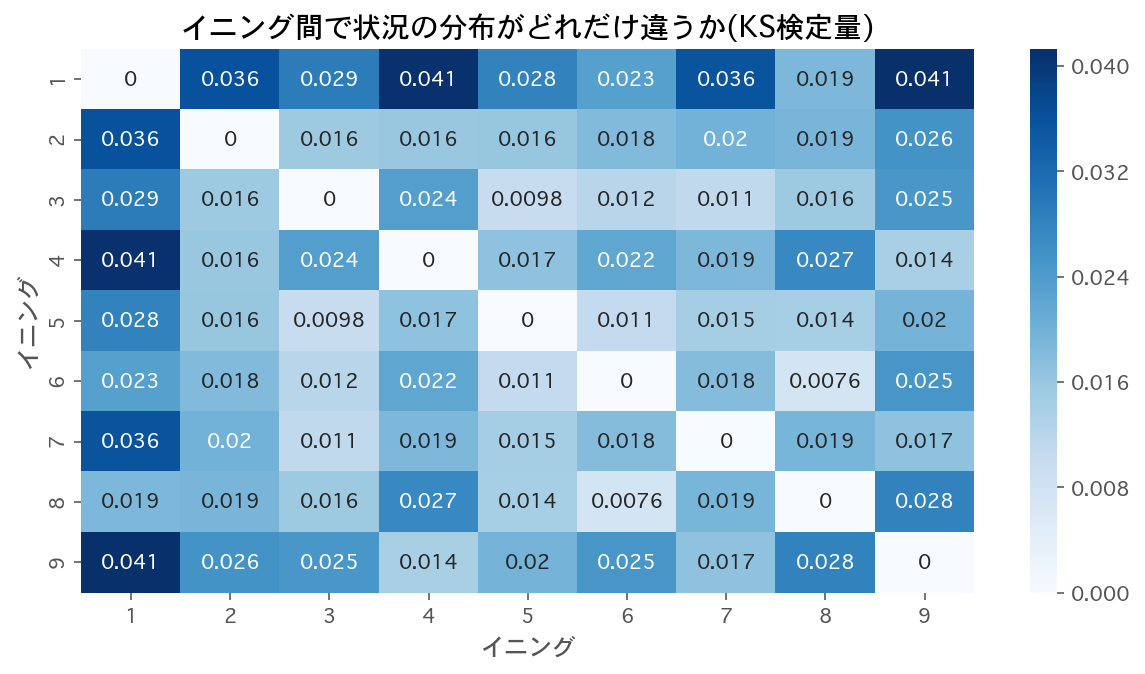

In [23]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_statistic_regular, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布がどれだけ違うか(KS検定量)")

In [24]:
# KS検定の結果
df_pvalue_regular = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df_pvalue_regular.iloc[i, j] = stats.ks_2samp(regular_inning_triple_index_list[i], regular_inning_triple_index_list[j]).pvalue

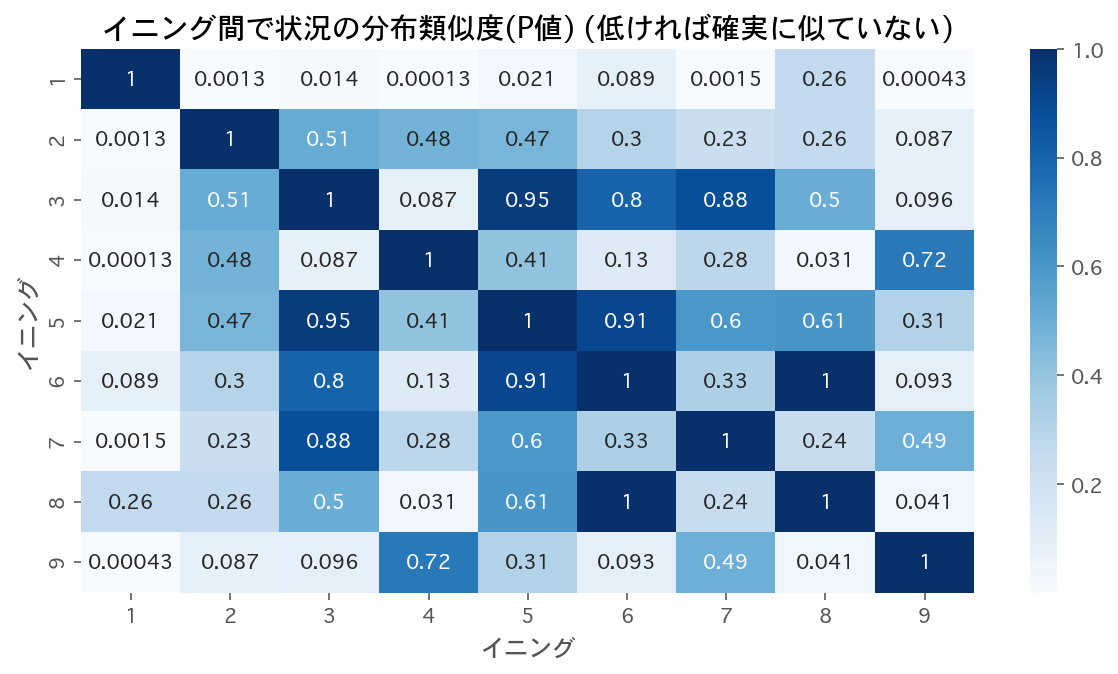

In [25]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_pvalue_regular, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布類似度(P値) (低ければ確実に似ていない)")

# POST
## POSTシーズンはやっぱりデータが足りなすぎる

In [26]:
post_event_df = make_df("20181013", "20181231")

In [27]:
post_event_df.shape

(1329, 15)

In [28]:
post_inning_list = make_inning_list(post_event_df)

In [29]:
post_triple = make_inning_triple(post_inning_list)

In [30]:
flattened_post_triple = []
for triple_list in post_triple:
    flattened_post_triple += triple_list
post_triple_set = set(flattened_post_triple)

In [31]:
# 状況とインデックスの対応dict
post_triple_dict = dict()
for i, triple in enumerate(post_triple_set):
    post_triple_dict[triple] = i
    
def to_index(lst):
    return [post_triple_dict[elem] for elem in lst]

In [32]:
post_inning_triple_index_list = []
for lst in post_triple:
    post_inning_triple_index_list.append(to_index(lst))

In [33]:
len(post_inning_triple_index_list), len(post_inning_triple_index_list[0])

(10, 96)

In [34]:
# KS検定の結果
df_statistic_post = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df_statistic_post.iloc[i, j] = stats.ks_2samp(post_inning_triple_index_list[i], post_inning_triple_index_list[j]).statistic

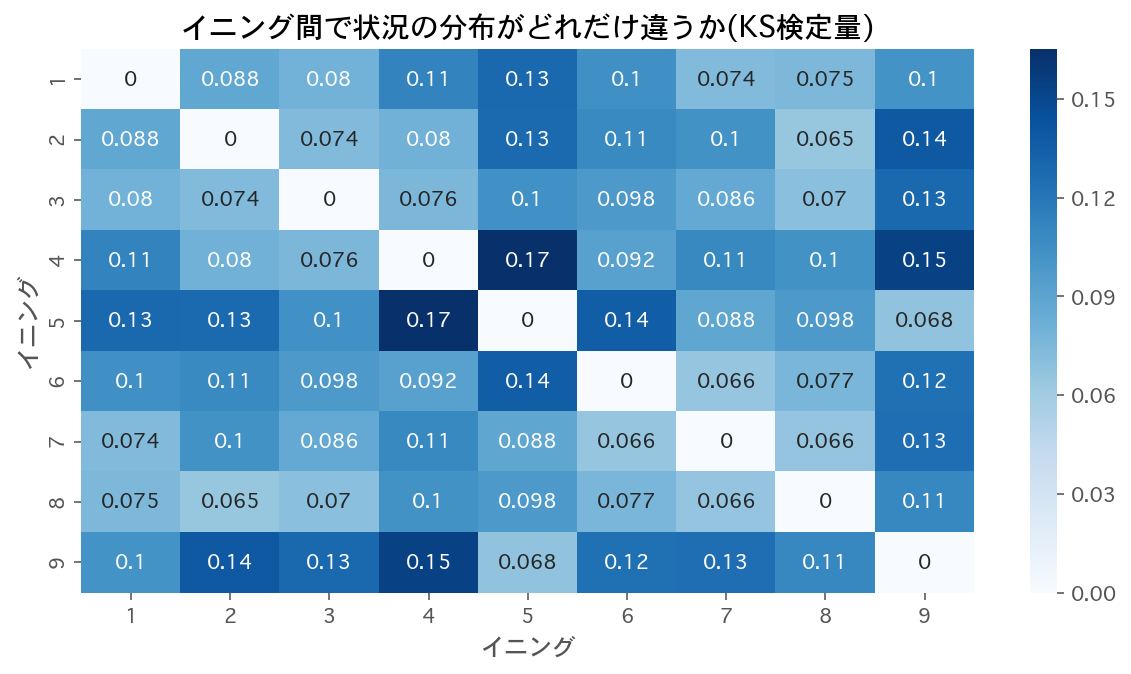

In [35]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_statistic_post, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布がどれだけ違うか(KS検定量)")

In [36]:
# KS検定の結果
df_pvalue_post = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df_pvalue_post.iloc[i, j] = stats.ks_2samp(post_inning_triple_index_list[i], post_inning_triple_index_list[j]).pvalue

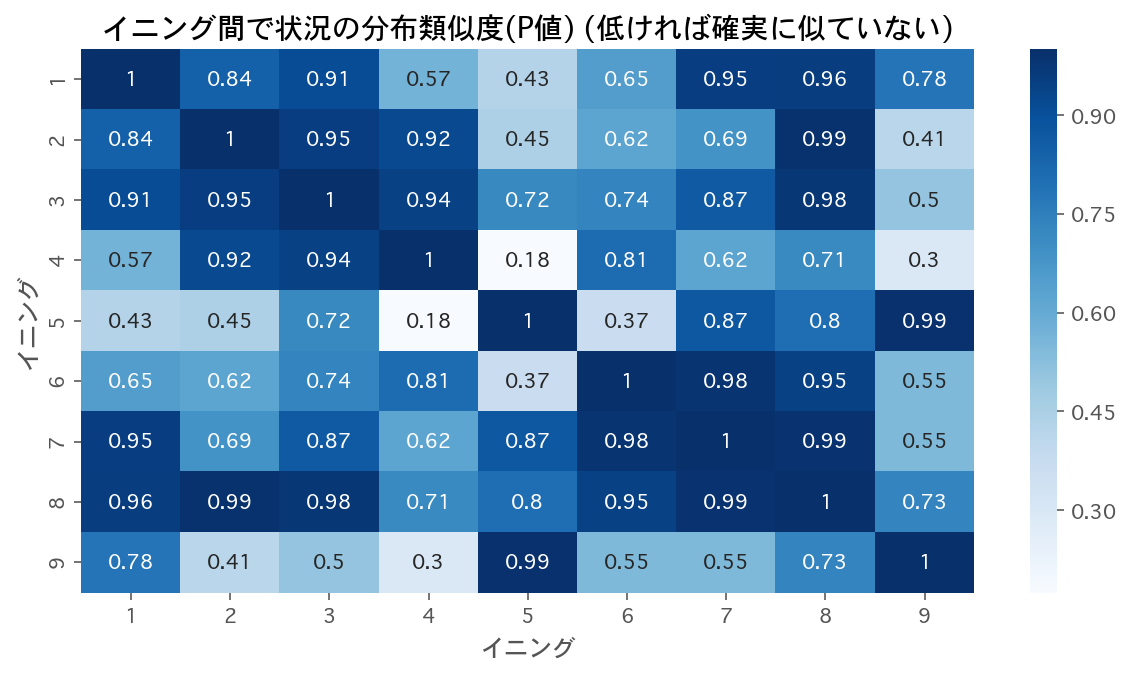

In [37]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_pvalue_post, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布類似度(P値) (低ければ確実に似ていない)")

# いらぬ

In [38]:
"""
def make_df(start, end):
    columns = ["状況", "回"]
    event_list = []
    file_list = os.listdir(DATA_DIR)[1:]
    
    date_series = pd.Series(file_list).apply(filename_to_datetime)
    target_file_list = list(pd.Series(file_list)[(date_series<pd.to_datetime(end)+pd.offsets.timedelta(1)) & (date_series>=pd.to_datetime(start))])
    
    for file in tq(target_file_list):
        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object")[columns].values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][0] == "2" and curr_event_list[i+1][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][1]])
                new_event_list.append(["0000", curr_event_list[i+1][1]])
        event_list.extend(new_event_list+[["GAMESET", np.nan]])
    for i in range(len(event_list)):
        if event_list[i][1] is np.nan:
            if event_list[i][0] != "GAMESET":
                event_list[i][1] = event_list[i-1][1]
    return pd.DataFrame(event_list, columns=columns)
"""

'\ndef make_df(start, end):\n    columns = ["状況", "回"]\n    event_list = []\n    file_list = os.listdir(DATA_DIR)[1:]\n    \n    date_series = pd.Series(file_list).apply(filename_to_datetime)\n    target_file_list = list(pd.Series(file_list)[(date_series<pd.to_datetime(end)+pd.offsets.timedelta(1)) & (date_series>=pd.to_datetime(start))])\n    \n    for file in tq(target_file_list):\n        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object")[columns].values.tolist()\n        new_event_list = []\n        for i in range(len(curr_event_list)):\n            new_event_list.append(curr_event_list[i])\n            if i < len(curr_event_list)-1 and curr_event_list[i][0] == "2" and curr_event_list[i+1][0] == "1":\n                new_event_list.append(["3000", curr_event_list[i][1]])\n                new_event_list.append(["0000", curr_event_list[i+1][1]])\n        event_list.extend(new_event_list+[["GAMESET", np.nan]])\n    for i in range(len(event_list

In [39]:
#file_list = os.listdir(DATA_DIR)[1:]

In [40]:
#date_series = pd.Series(file_list).apply(filename_to_datetime)

In [41]:
#pd.Series(file_list)[(date_series>=pd.to_datetime("20180505")) & (date_series<pd.to_datetime("20180510"))]